<a href="https://colab.research.google.com/github/Krish-mal15/Brain-Tumor-Segmentation-IGRT-Algorithms/blob/main/Brain_Tumor_UNET_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import os

optimizer = Adam(1e-4)
H = 256
W = 256

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")

    print('Input Shape: ', input_shape)
    return model


def load_dataset(path, split=0.2):
    images_train = sorted(glob(os.path.join(path, "train", "images", "*.png")))
    masks_train = sorted(glob(os.path.join(path, "train", "masks", "*.png")))

    images_valid = sorted(glob(os.path.join(path, "val", "images", "*.png")))
    masks_valid = sorted(glob(os.path.join(path, "val", "masks", "*.png")))

    images_test = sorted(glob(os.path.join(path, "test", "images", "*.png")))
    masks_test = sorted(glob(os.path.join(path, "test", "masks", "*.png")))

    return (images_train, masks_train), (images_valid, masks_valid), (images_test, masks_test)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)

    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)

    batch_size = 16
    num_epochs = 20

    dataset_path = "/tumor-segment-data/tumor-segment-data-split"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    input_shape = (256, 256, 3)
    model = build_unet(input_shape)

    model.compile(optimizer=optimizer, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

    model.summary()

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset

    )

    model.save('/UNET-Tumor-Model/UNET-tumor-segment-model.keras')


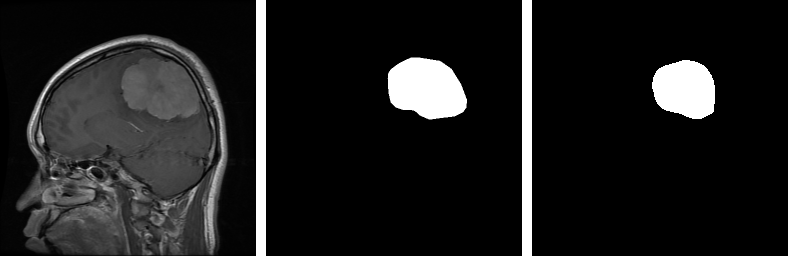

[0 0 0 ... 0 0 0]


In [16]:
from keras.models import load_model
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

H = 256
W = 256

model = load_model('/UNET-Tumor-Model/UNET-tumor-segment-model.keras')
# model.summary()

x = '/Test-Images/627.png'
y = '/Test-Images/627-mask.png'

image = cv2.imread(x, cv2.IMREAD_COLOR)
image = cv2.resize(image, (W, H))

x = image/255.0
x = np.expand_dims(x, axis=0)

mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (W, H))

y_pred = model.predict(x, verbose=0)[0]
y_pred = np.squeeze(y_pred, axis=-1)
y_pred = y_pred >= 0.5
y_pred = y_pred.astype(np.int32)

mask = np.expand_dims(mask, axis=-1)
mask = np.concatenate([mask, mask, mask], axis=-1)

y_pred = np.expand_dims(y_pred, axis=-1)
y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
y_pred = y_pred * 255

line = np.ones((H, 10, 3)) * 255

cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
cv2_imshow(cat_images)

mask = mask/255.0
mask = (mask > 0.5).astype(np.int32).flatten()
y_pred = y_pred.flatten()

print(y_pred)


In [4]:
import os
print(os.listdir('UNET-tumor-model'))

['fingerprint.pb', 'keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']


In [4]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
!unzip '/tumor-segment-data-split (2)'.zip -d '/tumor-segment-data'